# Graph coloring with the Pulser environment

## Setting up the virtual environment

In [1]:
import networkx as nx
from threading import Thread
import numpy as np
from pulser import Register
import math
import timeit
import pyomo.environ as pyo
import copy
import graphcolor
import pulser_pasqal
from pulser_pasqal import EmuFreeBackend
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice as my_device
from pulser_simulation import QutipEmulator, NoiseModel, EmulatorConfig
from pulser.waveforms import InterpolatedWaveform
import warnings
warnings.filterwarnings('ignore')

## Graph coloring in a hybrid setting

In what follows we set out to illustrate the hybrid column generation problem for graph coloring. For more details, please refer to <a href="https://arxiv.org/abs/2301.02637" target="_blank">the following publication</a>.

It is a bottoms-up type method that consists in decomposing the problem in the following way:

1. A Master Problem: Solving the (simplified) graph coloration problem on limited information
2. A Sub-Problem: Generating meaningful new information for the Master Problem
![Graph coloring example](graphcoloring.png)


![Hybrid column generation method overview](hybridcolumn.png)

The overall algorithm runs as follows:

![Hybrid method scheme](hybrid.png)

In [2]:
pasqal_cloud_connection = pulser_pasqal.PasqalCloud(project_id=graphcolor.PROJECT_ID, username=graphcolor.USER_NAME, password=graphcolor.PASSWORD)

In [3]:
class PulserSimRemote():
    @classmethod
    def run(cls, seq, N_samples=100):
        noise_model = NoiseModel()
        config = EmulatorConfig(backend_options={}, sampling_rate=0.25, noise_model=noise_model, evaluation_times="Final")
        job_list = [{"runs":N_samples}]
        bknd = EmuFreeBackend(seq, pasqal_cloud_connection, config=config)
        results = bknd.run(job_params=job_list)

        return results

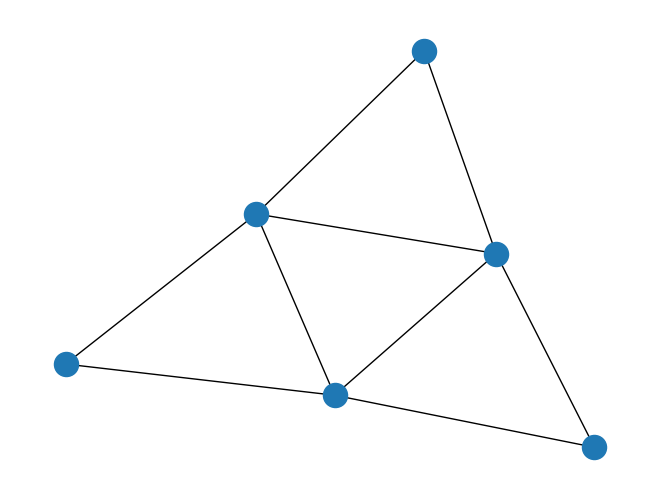

In [4]:
my_graph = nx.Graph()

# Design the graph
layout = my_device.calibrated_register_layouts["TriangularLatticeLayout(61, 5.0µm)"]
reg = layout.define_register(12, 26, 40, 39, 38, 25, qubit_ids=[0, 1, 2, 3, 4, 5])
my_graph.add_edges_from([(0,1), (1,2), (2,3), (3,4), (4,5), (5,0), (5,1), (1,3), (3,5)])

nx.draw(my_graph)

In [5]:
# Compute Omega
#get the enegergy of each pair of nodes
dc = []
for i in range(0, len(reg.qubits)):
    for j in range(0, i):
        dc.append(math.dist(reg.qubits[i], reg.qubits[j]))
Omega = my_device.interaction_coeff/(max(dc)**6) 

my_graph.graph['quantum_param'] = {'register' : reg, 'layout': layout, 'sequence': {'Omega': Omega, 'delta': 5, 'ev_time' : 3000}}

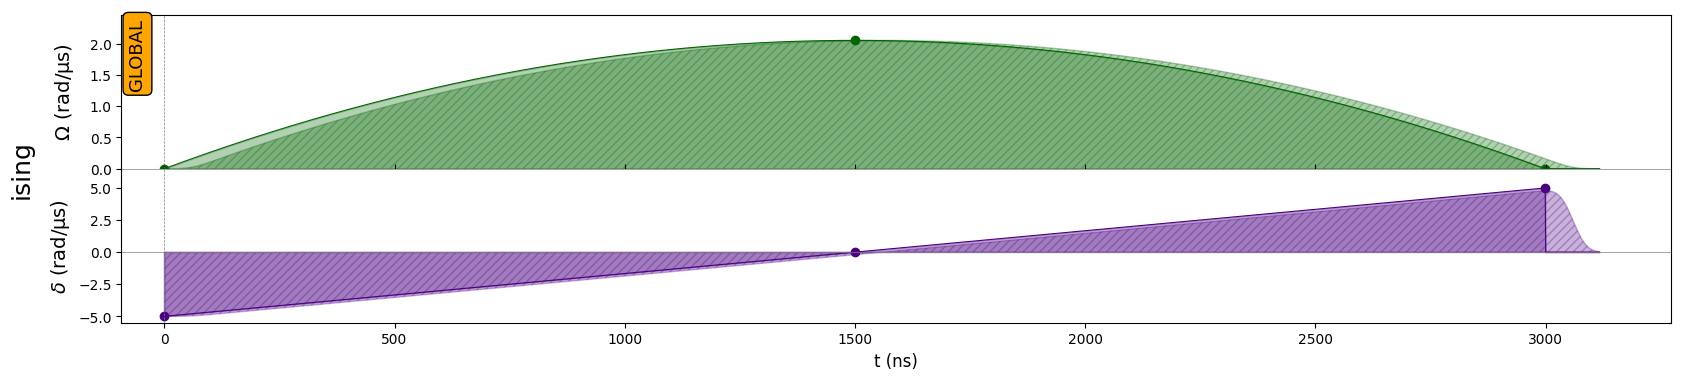

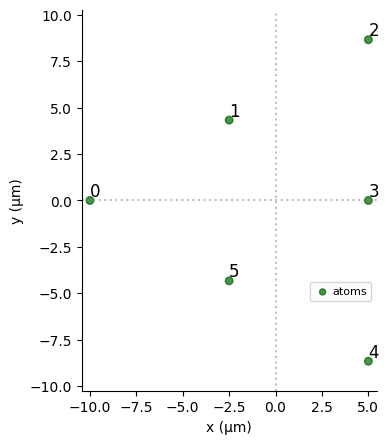

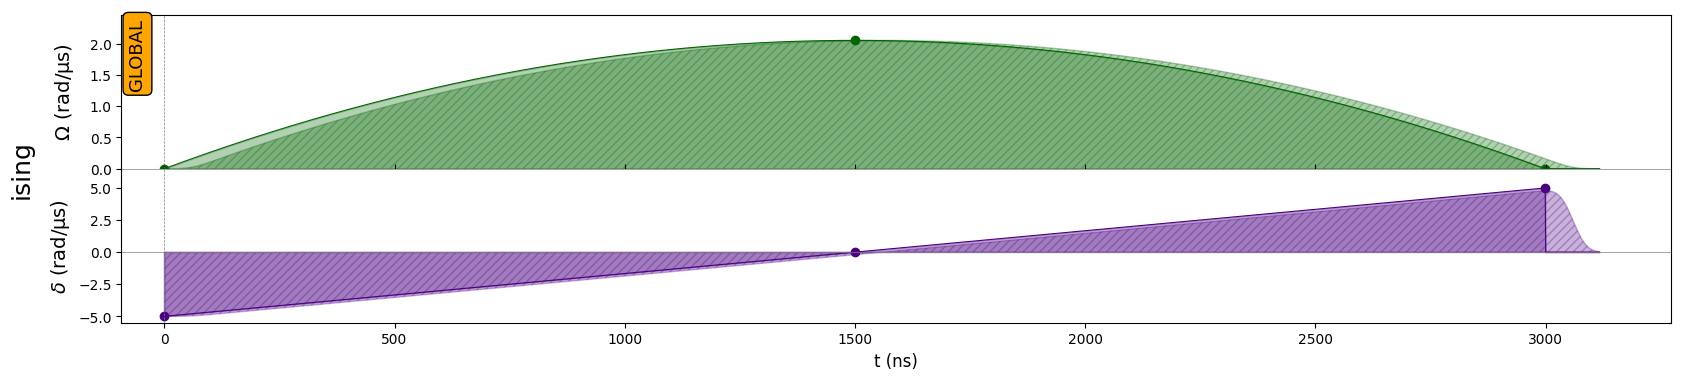

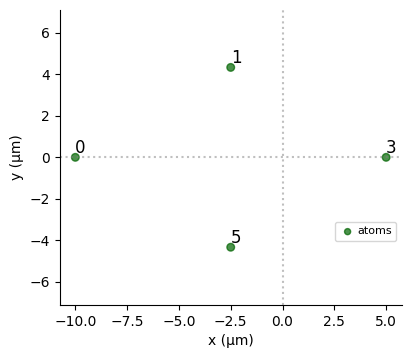

{2: 6, 5: 6, 1: 8, 4: 8, 0: 12, 3: 12}


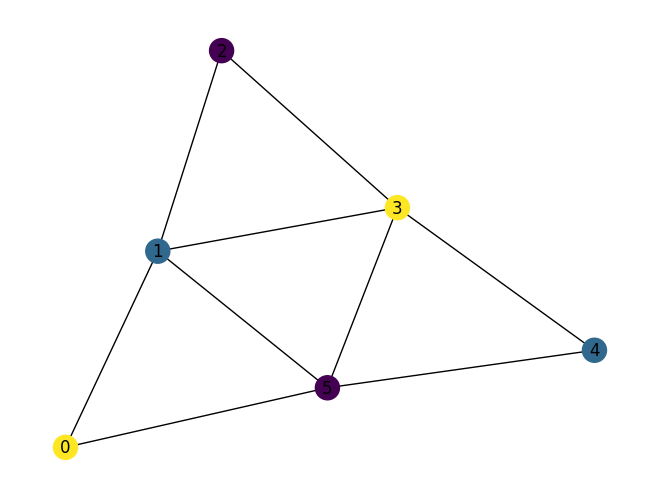

In [6]:
graphcolor.solve_quantum_CG(my_graph, backend=PulserSimRemote)

#dict, where keys are node indices and values are color indices
nx.draw(my_graph, with_labels = True, node_color=[my_graph.graph["quantum CG binary solution"][i] for i in range(0, 6)])

print(my_graph.graph["quantum CG binary solution"])